In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib
import networkx as nx

from adjustText import adjust_text

In [23]:
# custom package import
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
adata = sq.datasets.seqfish()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30.7M/30.7M [00:22<00:00, 1.42MB/s]
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:744: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:472: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:650: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

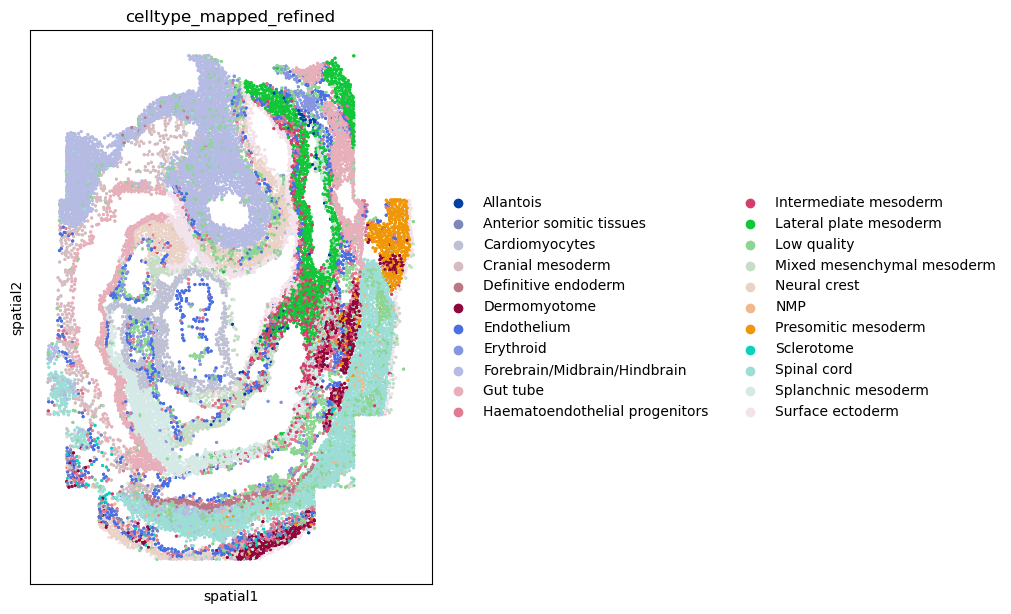

In [6]:
sq.pl.spatial_scatter(
    adata, color="celltype_mapped_refined", shape=None, figsize=(10, 10)
)

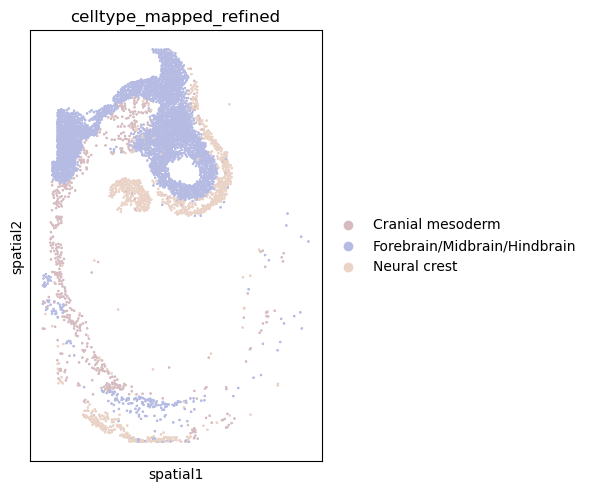

In [53]:
sq.pl.spatial_scatter(
    adata,
    color="celltype_mapped_refined",
    groups=[
        "Forebrain/Midbrain/Hindbrain",
        "Cranial mesoderm",
        "Neural crest"
    ],
    shape=None,
    size=2,
)

In [48]:
adata_sdm.obs.celltype_mapped_refined.value_counts()

celltype_mapped_refined
Forebrain/Midbrain/Hindbrain      3704
Spinal cord                       2620
Low quality                       1645
Gut tube                          1464
Lateral plate mesoderm            1243
Splanchnic mesoderm               1138
Endothelium                        953
Neural crest                       912
Surface ectoderm                   801
Cardiomyocytes                     737
Haematoendothelial progenitors     637
Intermediate mesoderm              623
Mixed mesenchymal mesoderm         541
Cranial mesoderm                   528
Dermomyotome                       523
Presomitic mesoderm                458
Erythroid                          300
Definitive endoderm                213
Anterior somitic tissues           112
NMP                                109
Sclerotome                          78
Allantois                           77
Name: count, dtype: int64

In [9]:
adata.layers['count'] = adata.X

In [12]:
adata.raw = adata.copy()

## Extract spatialsm LR

In [60]:
loc = adata.obsm['spatial']

loc_df = pd.DataFrame(loc).rename(columns = {0:"x", 1:"y"})
loc_df.loc[:,"cell"] = adata.obs_names
loc_df.set_index('cell', inplace=True)

In [61]:
loc_df

,x,y
cell,,
embryo1_Pos0_cell10_z2,0.729261,-2.821746
embryo1_Pos0_cell10_z5,0.708437,-2.707126
embryo1_Pos0_cell100_z2,0.961726,-2.943951
embryo1_Pos0_cell100_z5,0.976304,-2.517971
embryo1_Pos0_cell101_z2,0.959880,-3.000712
...,...,...
embryo1_Pos28_cell97_z2,-1.538899,2.664242
embryo1_Pos28_cell97_z5,-1.399228,3.176193
embryo1_Pos28_cell98_z2,-1.513958,2.625459


In [13]:
sdm.extract_lr(adata, 'mouse', min_cell=20)

In [59]:
adata_sdm = adata.copy()
sdm.weight_matrix(adata_sdm, l=20, single_cell=False)

In [58]:
plt.hist(adata_sdm.obsp['weight'].toarray().sum(0));

KeyError: 'weight'

In [40]:
import time
start = time.time()
sdm.spatialdm_global(adata_sdm, 1000, specified_ind=None, method='both', nproc=1)     # global Moran selection
sdm.sig_pairs(adata_sdm, method='permutation', fdr=True, threshold=0.1)     # select significant pairs
print("%.3f seconds" %(time.time()-start))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.52it/s]

61.103 seconds


In [42]:
print(adata_sdm.uns['global_res'].selected.sum())
adata_sdm.uns['global_res'].sort_values(by='fdr').head()

48


,Ligand0,Receptor0,Receptor1,z_pval,z,perm_pval,fdr,selected
ESAM_ESAM,Esam,Esam,None,0.000000e+00,127.755988,0.0,0.0,True
FGF10_FGFR2,Fgf10,Fgfr2,None,0.000000e+00,59.707473,0.0,0.0,True
NODAL_ACVR1C_ACVR2A,Nodal,Acvr2a,None,9.751066e-121,23.335153,0.0,0.0,True
NODAL_ACVR1B_ACVR2A,Nodal,Acvr2a,None,9.751066e-121,23.335153,0.0,0.0,True
FGF5_FGFR4,Fgf5,Fgfr4,None,1.423391e-109,22.208436,0.0,0.0,True


In [43]:
adata_sdm.uns['global_res']

,Ligand0,Receptor0,Receptor1,z_pval,z,perm_pval,fdr,selected
ESAM_ESAM,Esam,Esam,None,0.000000e+00,127.755988,0.000,0.000000,True
EFNA5_EPHA5,Efna5,Epha5,None,1.032899e-11,6.701296,0.065,0.086667,True
CDH2_CDH2,Cdh2,Cdh2,None,0.000000e+00,161.512358,0.000,0.000000,True
CDH1_CDH1,Cdh1,Cdh1,None,0.000000e+00,182.477148,0.000,0.000000,True
CDH5_CDH5,Cdh5,Cdh5,None,0.000000e+00,149.732970,0.000,0.000000,True
...,...,...,...,...,...,...,...,...
FGF10_FGFR1,Fgf10,Fgfr1,None,1.256712e-200,30.198037,0.000,0.000000,True
FGF3_FGFR2,Fgf3,Fgfr2,None,1.000000e+00,-40.938099,1.000,1.000000,False
FGF3_FGFR1,Fgf3,Fgfr1,None,1.000000e+00,-26.407808,1.000,1.000000,False
FGF5_FGFR4,Fgf5,Fgfr4,None,1.423391e-109,22.208436,0.000,0.000000,True


In [20]:
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'
    obsm: 'X_umap', 'spatial'
    layers: 'count'

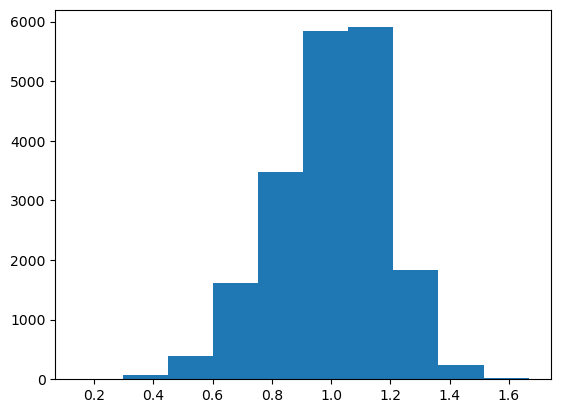

In [25]:
plt.hist(adata_sdm.obsp['weight'].toarray().sum(0));

In [27]:
adata.obs.loc[:, 'celltype'] = adata.obs.celltype_mapped_refined

## Construct the spatial graph and prepare to run copulacci

In [29]:
G = nx.from_scipy_sparse_array(adata_sdm.obsp['nearest_neighbors'])
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata, 
    G = G,
    weight_mat=adata_sdm.obsp['weight']
)
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.raw.to_adata().to_df().loc[:,chosen_lr]
lig_list = adata.uns['ligand'].values
rec_list = adata.uns['receptor'].values

data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_new,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

relabeling nodes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 412/412 [00:17<00:00, 23.60it/s]


## Run copula

In [30]:
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

cop_df_dict = model.run_copula(
    data_list_dict,
    umi_sums,
    dist_list_dict,
    DT=False,
    cutoff = 0.8,
    type_run='dense',
    num_restarts=1,
    df_lig_rec=df_lig_rec,
    heteronomic=True
)

Gut tube=Gut tube


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    7.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan(

Erythroid=Erythroid
Lateral plate mesoderm=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cranial mesoderm=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Neural crest=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Endothelium=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Spinal cord=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Presomitic mesoderm=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarnin

Low quality=Low quality
Mixed mesenchymal mesoderm=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cardiomyocytes=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Dermomyotome=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packag

Definitive endoderm=Definitive endoderm
Low quality=Lateral plate mesoderm
Lateral plate mesoderm=Low quality
Low quality=Allantois
Allantois=Low quality


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Lateral plate mesoderm=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Intermediate mesoderm=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_m

Erythroid=Low quality
Low quality=Erythroid
Lateral plate mesoderm=Erythroid
Erythroid=Lateral plate mesoderm
Allantois=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Allantois


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Allantois=Erythroid
Erythroid=Allantois
Allantois=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Lateral plate mesoderm=Allantois


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      |

Low quality=Gut tube
Gut tube=Low quality
Low quality=Endothelium
Endothelium=Low quality
Lateral plate mesoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Endothelium


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Haematoendothelial progenitors=Erythroid
Erythroid=Haematoendothelial progenitors
Haematoendothelial progenitors=Low quality


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Low quality=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Erythroid=Endothelium
Endothelium=Erythroid
Intermediate mesoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Erythroid=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Mixed mesenchymal mesoderm=Erythroid


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Endothelium=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Lateral plate mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Gut tube=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Haematoendothelial progenitors=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Allantois=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mixed mesenchymal mesoderm=Allantois


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Endothelium=Allantois


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Allantois=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Intermediate mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:472: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 

Intermediate mesoderm=Low quality
Low quality=Intermediate mesoderm
Erythroid=Gut tube
Gut tube=Erythroid
Mixed mesenchymal mesoderm=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Lateral plate mesoderm=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mixed mesenchymal mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mixed mesenchymal mesoderm=Haematoendothelial progenitors
Haematoendothelial progenitors=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Mixed mesenchymal mesoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mixed mesenchymal mesoderm=Low quality
Low quality=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Lateral plate mesoderm=Gut tube


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Gut tube=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Endothelium=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Neural crest=Endothelium


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Allantois=Spinal cord
Spinal cord=Allantois
Spinal cord=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Lateral plate mesoderm=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Spinal cord=Low quality
Low quality=Spinal cord
Lateral plate mesoderm=Neural crest
Neural crest=Lateral plate mesoderm
Neural crest=Low quality
Low quality=Neural crest
Neural crest=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Intermediate mesoderm=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Lateral plate mesoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mixed mesenchymal mesoderm=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mixed mesenchymal mesoderm=Intermediate mesoderm
Forebrain/Midbrain/Hindbrain=Low quality


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Low quality=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Neural crest=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Forebrain/Midbrain/Hindbrain=Erythroid
Erythroid=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Spinal cord=Forebrain/Midbrain/Hindbrain
Low quality=Cranial mesoderm
Cranial mesoderm=Low quality
Forebrain/Midbrain/Hindbrain=Endothelium


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Forebrain/Midbrain/Hindbrain=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Neural crest=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Neural crest=Erythroid
Erythroid=Neural crest
Neural crest=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Cranial mesoderm=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cranial mesoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Haematoendothelial progenitors=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Cranial mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Cranial mesoderm=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Forebrain/Midbrain/Hindbrain=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Surface ectoderm=Low quality
Low quality=Surface ectoderm
Surface ectoderm=Cranial mesoderm
Cranial mesoderm=Surface ectoderm
Surface ectoderm=Erythroid
Erythroid=Surface ectoderm
Cranial mesoderm=Erythroid
Erythroid=Cranial mesoderm
Neural crest=Surface ectoderm


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Surface ectoderm=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=Lateral plate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Lateral plate mesoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Surface ectoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Haematoendothelial progenitors=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Neural crest=Mixed mesenchymal mesoderm
Mixed mesenchymal mesoderm=Neural crest
Mixed mesenchymal mesoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Surface ectoderm=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Surface ectoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Endothelium=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Surface ectoderm=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Intermediate mesoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Definitive endoderm=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Forebrain/Midbrain/Hindbrain=Definitive endoderm
Definitive endoderm=Low quality
Low quality=Definitive endoderm
Neural crest=Spinal cord


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Spinal cord=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Definitive endoderm=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Cranial mesoderm=Definitive endoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Spinal cord=Cranial mesoderm
Cranial mesoderm=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Cranial mesoderm=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Gut tube=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Gut tube
Gut tube=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Neural crest=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=Definitive endoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Definitive endoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Haematoendothelial progenitors=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Spinal cord=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Gut tube=Spinal cord
Spinal cord=Gut tube
Surface ectoderm=Forebrain/Midbrain/Hindbrain


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Forebrain/Midbrain/Hindbrain=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Surface ectoderm=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Spinal cord=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Spinal cord=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Endothelium=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished


Forebrain/Midbrain/Hindbrain=NMP
NMP=Forebrain/Midbrain/Hindbrain
Spinal cord=Definitive endoderm


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Definitive endoderm=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Forebrain/Midbrain/Hindbrain=Splanchnic mesoderm
Splanchnic mesoderm=Forebrain/Midbrain/Hindbrain
Splanchnic mesoderm=Low quality
Low quality=Splanchnic mesoderm
Neural crest=Anterior somitic tissues


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Anterior somitic tissues=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Anterior somitic tissues=Low quality
Low quality=Anterior somitic tissues
Anterior somitic tissues=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cranial mesoderm=Anterior somitic tissues
Allantois=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Allantois
Splanchnic mesoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Haematoendothelial progenitors=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Endothelium=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Splanchnic mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Allantois
Allantois=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished


Splanchnic mesoderm=Spinal cord
Spinal cord=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Erythroid
Erythroid=Intermediate mesoderm
Spinal cord=NMP


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


NMP=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Low quality=Presomitic mesoderm
Presomitic mesoderm=Low quality
Low quality=Dermomyotome
Dermomyotome=Low quality
Endothelium=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Presomitic mesoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Dermomyotome=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Presomitic mesoderm=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Dermomyotome=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Dermomyotome=Definitive endoderm
Definitive endoderm=Dermomyotome
Haematoendothelial progenitors=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Presomitic mesoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Haematoendothelial progenitors=Definitive endoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Definitive endoderm=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Presomitic mesoderm=Gut tube
Gut tube=Presomitic mesoderm
Definitive endoderm=Presomitic mesoderm
Presomitic mesoderm=Definitive endoderm
Definitive endoderm=Gut tube
Gut tube=Definitive endoderm
Dermomyotome=NMP


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


NMP=Dermomyotome


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Dermomyotome=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Spinal cord=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Presomitic mesoderm=NMP
NMP=Presomitic mesoderm
NMP=Low quality
Low quality=NMP
Presomitic mesoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Dermomyotome=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Presomitic mesoderm=Mixed mesenchymal mesoderm
Mixed mesenchymal mesoderm=Presomitic mesoderm
Gut tube=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Intermediate mesoderm=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Spinal cord=Intermediate mesoderm
Intermediate mesoderm=Spinal cord
Neural crest=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Neural crest


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surface ectoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Neural crest=Definitive endoderm
Definitive endoderm=Neural crest
Mixed mesenchymal mesoderm=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cardiomyocytes=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Low quality=Cardiomyocytes
Cardiomyocytes=Low quality
Definitive endoderm=Cardiomyocytes
Cardiomyocytes=Definitive endoderm
Cardiomyocytes=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surface ectoderm=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Definitive endoderm=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Definitive endoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cardiomyocytes=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Erythroid=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Splanchnic mesoderm=Erythroid


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Cardiomyocytes=Neural crest
Neural crest=Cardiomyocytes
Gut tube=Anterior somitic tissues
Anterior somitic tissues=Gut tube
Cardiomyocytes=Cranial mesoderm
Cranial mesoderm=Cardiomyocytes
Cardiomyocytes=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Cardiomyocytes=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Haematoendothelial progenitors=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished


Cranial mesoderm=Splanchnic mesoderm
Definitive endoderm=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Splanchnic mesoderm=Definitive endoderm
Cardiomyocytes=Erythroid


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Erythroid=Cardiomyocytes


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Mixed mesenchymal mesoderm=Definitive endoderm
Definitive endoderm=Mixed mesenchymal mesoderm
Cardiomyocytes=Allantois
Allantois=Cardiomyocytes
Intermediate mesoderm=Definitive endoderm
Definitive endoderm=Intermediate mesoderm
Gut tube=Allantois
Allantois=Gut tube
Surface ectoderm=Allantois


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Allantois=Surface ectoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Spinal cord=Mixed mesenchymal mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Mixed mesenchymal mesoderm=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Intermediate mesoderm=NMP
NMP=Intermediate mesoderm
NMP=Lateral plate mesoderm
Lateral plate mesoderm=NMP
Spinal cord=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Presomitic mesoderm=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Intermediate mesoderm=Presomitic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Presomitic mesoderm=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Splanchnic mesoderm=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Dermomyotome=Splanchnic mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Intermediate mesoderm=Dermomyotome


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Dermomyotome=Intermediate mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Usin

Intermediate mesoderm=Anterior somitic tissues
Anterior somitic tissues=Intermediate mesoderm
Lateral plate mesoderm=Dermomyotome
Dermomyotome=Lateral plate mesoderm
Spinal cord=Anterior somitic tissues


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Anterior somitic tissues=Spinal cord


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Anterior somitic tissues=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Dermomyotome=Anterior somitic tissues


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Surface ectoderm=NMP
NMP=Surface ectoderm
Intermediate mesoderm=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Cranial mesoderm=Intermediate mesoderm
NMP=Splanchnic mesoderm
Splanchnic mesoderm=NMP


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Usin

Neural crest=NMP
NMP=Neural crest
Lateral plate mesoderm=Presomitic mesoderm
Presomitic mesoderm=Lateral plate mesoderm
Splanchnic mesoderm=Presomitic mesoderm
Presomitic mesoderm=Splanchnic mesoderm
Cranial mesoderm=NMP
NMP=Cranial mesoderm
Spinal cord=Sclerotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Sclerotome=Spinal cord
Intermediate mesoderm=Sclerotome
Sclerotome=Intermediate mesoderm
Dermomyotome=Sclerotome


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Sclerotome=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Low quality=Sclerotome
Sclerotome=Low quality
Sclerotome=NMP
NMP=Sclerotome
Intermediate mesoderm=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Intermediate mesoderm
Dermomyotome=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Dermomyotome
Cranial mesoderm=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Dermomyotome=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Dermomyotome


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Dermomyotome=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Anterior somitic tissues=Presomitic mesoderm
Presomitic mesoderm=Anterior somitic tissues
Forebrain/Midbrain/Hindbrain=Presomitic mesoderm
Presomitic mesoderm=Forebrain/Midbrain/Hindbrain
NMP=Gut tube
Gut tube=NMP
Dermomyotome=Gut tube
Gut tube=Dermomyotome
Presomitic mesoderm=Cranial mesoderm


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Usin

Cranial mesoderm=Presomitic mesoderm
Presomitic mesoderm=Sclerotome
Sclerotome=Presomitic mesoderm
Splanchnic mesoderm=Anterior somitic tissues
Anterior somitic tissues=Splanchnic mesoderm
Dermomyotome=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Neural crest=Dermomyotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Anterior somitic tissues=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=Anterior somitic tissues


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Haematoendothelial progenitors=Anterior somitic tissues


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Anterior somitic tissues=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Cranial mesoderm=Lateral plate mesoderm
Lateral plate mesoderm=Cranial mesoderm
Erythroid=Spinal cord
Spinal cord=Erythroid
Erythroid=Dermomyotome
Dermomyotome=Erythroid
NMP=Haematoendothelial progenitors
Haematoendothelial progenitors=NMP
NMP=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Endothelium=NMP
Anterior somitic tissues=Sclerotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Sclerotome=Anterior somitic tissues


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s


Haematoendothelial progenitors=Sclerotome


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Sclerotome=Haematoendothelial progenitors


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished


Sclerotome=Cranial mesoderm
Cranial mesoderm=Sclerotome


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Sclerotome


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Sclerotome=Endothelium


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Intermediate mesoderm=Cardiomyocytes
Cardiomyocytes=Intermediate mesoderm
Sclerotome=Splanchnic mesoderm
Splanchnic mesoderm=Sclerotome
Forebrain/Midbrain/Hindbrain=Anterior somitic tissues
Anterior somitic tissues=Forebrain/Midbrain/Hindbrain
Sclerotome=Neural crest
Neural crest=Sclerotome
Anterior somitic tissues=Definitive endoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_

Definitive endoderm=Anterior somitic tissues
Erythroid=Anterior somitic tissues
Anterior somitic tissues=Erythroid
Definitive endoderm=Erythroid
Erythroid=Definitive endoderm
Surface ectoderm=Sclerotome
Sclerotome=Surface ectoderm
Erythroid=Sclerotome
Sclerotome=Erythroid


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Usin

Presomitic mesoderm=Neural crest
Neural crest=Presomitic mesoderm
Definitive endoderm=Sclerotome
Sclerotome=Definitive endoderm
Sclerotome=Forebrain/Midbrain/Hindbrain
Forebrain/Midbrain/Hindbrain=Sclerotome
Surface ectoderm=Anterior somitic tissues
Anterior somitic tissues=Surface ectoderm


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


## Run SCC

In [31]:
cop_df_dict = model.run_scc(
    count_df,
    None,
    cop_df_dict,
    int_edges_new,
    groups = list(data_list_dict.keys()),
    heteronomic=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization = "sum"
)

Gut tube=Gut tube
Graph with 722 nodes and 2333 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    6.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0


Erythroid=Erythroid
Graph with 39 nodes and 129 edges
Lateral plate mesoderm=Lateral plate mesoderm
Graph with 357 nodes and 1100 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain
Graph with 2230 nodes and 7534 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    1.4s finished


Surface ectoderm=Surface ectoderm
Graph with 145 nodes and 391 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Cranial mesoderm=Cranial mesoderm
Graph with 95 nodes and 266 edges


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Neural crest=Neural crest
Graph with 210 nodes and 565 edges
Endothelium=Endothelium
Graph with 28 nodes and 67 edges
Spinal cord=Spinal cord
Graph with 741 nodes and 2009 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Presomitic mesoderm=Presomitic mesoderm
Graph with 217 nodes and 707 edges
Low quality=Low quality
Graph with 72 nodes and 168 edges
Mixed mesenchymal mesoderm=Mixed mesenchymal mesoderm
Graph with 79 nodes and 215 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cardiomyocytes=Cardiomyocytes
Graph with 419 nodes and 1394 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Dermomyotome=Dermomyotome
Graph with 18 nodes and 27 edges
Splanchnic mesoderm=Splanchnic mesoderm
Graph with 483 nodes and 1651 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0


Definitive endoderm=Definitive endoderm
Graph with 11 nodes and 15 edges
Low quality=Lateral plate mesoderm
DiGraph with 261 nodes and 225 edges


/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Lateral plate mesoderm=Low quality
DiGraph with 261 nodes and 225 edges
Low quality=Allantois
DiGraph with 35 nodes and 22 edges
Allantois=Low quality
DiGraph with 35 nodes and 22 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Lateral plate mesoderm=Intermediate mesoderm
DiGraph with 821 nodes and 883 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Intermediate mesoderm=Lateral plate mesoderm
DiGraph with 821 nodes and 883 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Erythroid=Low quality
DiGraph with 513 nodes and 541 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Low quality=Erythroid
DiGraph with 513 nodes and 541 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0


Lateral plate mesoderm=Erythroid
DiGraph with 24 nodes and 19 edges
Erythroid=Lateral plate mesoderm
DiGraph with 24 nodes and 19 edges
Allantois=Haematoendothelial progenitors
DiGraph with 39 nodes and 25 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Haematoendothelial progenitors=Allantois
DiGraph with 39 nodes and 25 edges
Allantois=Erythroid
DiGraph with 8 nodes and 5 edges
Erythroid=Allantois
DiGraph with 8 nodes and 5 edges
Allantois=Lateral plate mesoderm
DiGraph with 145 nodes and 124 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elaps

Lateral plate mesoderm=Allantois
DiGraph with 145 nodes and 124 edges
Endothelium=Gut tube
DiGraph with 329 nodes and 317 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Gut tube=Endothelium
DiGraph with 329 nodes and 317 edges
Low quality=Gut tube
DiGraph with 339 nodes and 286 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Gut tube=Low quality
DiGraph with 339 nodes and 286 edges
Low quality=Endothelium
DiGraph with 683 nodes and 564 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished


Endothelium=Low quality
DiGraph with 683 nodes and 564 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Lateral plate mesoderm=Haematoendothelial progenitors
DiGraph with 304 nodes and 246 edges
Haematoendothelial progenitors=Lateral plate mesoderm
DiGraph with 304 nodes and 246 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Haematoendothelial progenitors=Endothelium
DiGraph with 930 nodes and 758 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Endothelium=Haematoendothelial progenitors
DiGraph with 930 nodes and 758 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Haematoendothelial progenitors=Erythroid
DiGraph with 78 nodes and 47 edges
Erythroid=Haematoendothelial progenitors
DiGraph with 78 nodes and 47 edges
Haematoendothelial progenitors=Low quality
DiGraph with 471 nodes and 350 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Low quality=Haematoendothelial progenitors
DiGraph with 471 nodes and 350 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Erythroid=Endothelium
DiGraph with 241 nodes and 196 edges
Endothelium=Erythroid
DiGraph with 241 nodes and 196 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Intermediate mesoderm=Haematoendothelial progenitors
DiGraph with 270 nodes and 195 edges
Haematoendothelial progenitors=Intermediate mesoderm
DiGraph with 270 nodes and 195 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Erythroid=Mixed mesenchymal mesoderm
DiGraph with 38 nodes and 28 edges
Mixed mesenchymal mesoderm=Erythroid
DiGraph with 38 nodes and 28 edges
Endothelium=Lateral plate mesoderm
DiGraph with 265 nodes and 211 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Lateral plate mesoderm=Endothelium
DiGraph with 265 nodes and 211 edges
Gut tube=Haematoendothelial progenitors
DiGraph with 182 nodes and 140 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Haematoendothelial progenitors=Gut tube
DiGraph with 182 nodes and 140 edges
Allantois=Mixed mesenchymal mesoderm
DiGraph with 141 nodes and 124 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Mixed mesenchymal mesoderm=Allantois
DiGraph with 141 nodes and 124 edges
Endothelium=Allantois
DiGraph with 37 nodes and 23 edges
Allantois=Endothelium
DiGraph with 37 nodes and 23 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Intermediate mesoderm=Endothelium
DiGraph with 173 nodes and 123 edges
Endothelium=Intermediate mesoderm
DiGraph with 173 nodes and 123 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Low quality
DiGraph with 326 nodes and 240 edges
Low quality=Intermediate mesoderm
DiGraph with 326 nodes and 240 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Erythroid=Gut tube
DiGraph with 23 nodes and 18 edges
Gut tube=Erythroid
DiGraph with 23 nodes and 18 edges
Mixed mesenchymal mesoderm=Lateral plate mesoderm
DiGraph with 179 nodes and 155 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elaps

Lateral plate mesoderm=Mixed mesenchymal mesoderm
DiGraph with 179 nodes and 155 edges
Mixed mesenchymal mesoderm=Endothelium
DiGraph with 154 nodes and 128 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Endothelium=Mixed mesenchymal mesoderm
DiGraph with 154 nodes and 128 edges
Mixed mesenchymal mesoderm=Haematoendothelial progenitors
DiGraph with 211 nodes and 175 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Haematoendothelial progenitors=Mixed mesenchymal mesoderm
DiGraph with 211 nodes and 175 edges
Mixed mesenchymal mesoderm=Splanchnic mesoderm
DiGraph with 209 nodes and 185 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Splanchnic mesoderm=Mixed mesenchymal mesoderm
DiGraph with 209 nodes and 185 edges
Mixed mesenchymal mesoderm=Low quality
DiGraph with 103 nodes and 80 edges
Low quality=Mixed mesenchymal mesoderm
DiGraph with 103 nodes and 80 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]

Lateral plate mesoderm=Gut tube
DiGraph with 104 nodes and 78 edges
Gut tube=Lateral plate mesoderm
DiGraph with 104 nodes and 78 edges
Endothelium=Neural crest
DiGraph with 354 nodes and 298 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Endothelium
DiGraph with 354 nodes and 298 edges
Allantois=Spinal cord
DiGraph with 6 nodes and 3 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Spinal cord=Allantois
DiGraph with 6 nodes and 3 edges
Spinal cord=Lateral plate mesoderm
DiGraph with 69 nodes and 55 edges
Lateral plate mesoderm=Spinal cord
DiGraph with 69 nodes and 55 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Spinal cord=Low quality
DiGraph with 1510 nodes and 1623 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.8s finished


Low quality=Spinal cord
DiGraph with 1510 nodes and 1623 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Lateral plate mesoderm=Neural crest
DiGraph with 6 nodes and 4 edges
Neural crest=Lateral plate mesoderm
DiGraph with 6 nodes and 4 edges
Neural crest=Low quality
DiGraph with 451 nodes and 428 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Low quality=Neural crest
DiGraph with 451 nodes and 428 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Neural crest=Intermediate mesoderm
DiGraph with 48 nodes and 36 edges
Intermediate mesoderm=Neural crest
DiGraph with 48 nodes and 36 edges
Lateral plate mesoderm=Splanchnic mesoderm
DiGraph with 212 nodes and 177 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Splanchnic mesoderm=Lateral plate mesoderm
DiGraph with 212 nodes and 177 edges
Intermediate mesoderm=Splanchnic mesoderm
DiGraph with 295 nodes and 257 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Splanchnic mesoderm=Intermediate mesoderm
DiGraph with 295 nodes and 257 edges
Gut tube=Mixed mesenchymal mesoderm
DiGraph with 35 nodes and 26 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Mixed mesenchymal mesoderm=Gut tube
DiGraph with 35 nodes and 26 edges
Intermediate mesoderm=Mixed mesenchymal mesoderm
DiGraph with 149 nodes and 128 edges
Mixed mesenchymal mesoderm=Intermediate mesoderm
DiGraph with 149 nodes and 128 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Forebrain/Midbrain/Hindbrain=Low quality
DiGraph with 1295 nodes and 1250 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished


Low quality=Forebrain/Midbrain/Hindbrain
DiGraph with 1295 nodes and 1250 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Forebrain/Midbrain/Hindbrain=Neural crest
DiGraph with 232 nodes and 195 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Neural crest=Forebrain/Midbrain/Hindbrain
DiGraph with 232 nodes and 195 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Forebrain/Midbrain/Hindbrain=Erythroid
DiGraph with 9 nodes and 7 edges
Erythroid=Forebrain/Midbrain/Hindbrain
DiGraph with 9 nodes and 7 edges
Forebrain/Midbrain/Hindbrain=Spinal cord
DiGraph with 889 nodes and 848 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.3s finished


Spinal cord=Forebrain/Midbrain/Hindbrain
DiGraph with 889 nodes and 848 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Low quality=Cranial mesoderm
DiGraph with 208 nodes and 149 edges
Cranial mesoderm=Low quality
DiGraph with 208 nodes and 149 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Forebrain/Midbrain/Hindbrain=Endothelium
DiGraph with 109 nodes and 88 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Endothelium=Forebrain/Midbrain/Hindbrain
DiGraph with 109 nodes and 88 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Haematoendothelial progenitors=Forebrain/Midbrain/Hindbrain
DiGraph with 75 nodes and 49 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Forebrain/Midbrain/Hindbrain=Haematoendothelial progenitors
DiGraph with 75 nodes and 49 edges
Haematoendothelial progenitors=Neural crest
DiGraph with 204 nodes and 163 edges
Neural crest=Haematoendothelial progenitors
DiGraph with 204 nodes and 163 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Neural crest=Erythroid
DiGraph with 36 nodes and 25 edges
Erythroid=Neural crest
DiGraph with 36 nodes and 25 edges
Neural crest=Cranial mesoderm
DiGraph with 214 nodes and 172 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cranial mesoderm=Neural crest
DiGraph with 214 nodes and 172 edges
Cranial mesoderm=Haematoendothelial progenitors
DiGraph with 166 nodes and 125 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Haematoendothelial progenitors=Cranial mesoderm
DiGraph with 166 nodes and 125 edges
Cranial mesoderm=Endothelium
DiGraph with 218 nodes and 181 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Endothelium=Cranial mesoderm
DiGraph with 218 nodes and 181 edges
Cranial mesoderm=Forebrain/Midbrain/Hindbrain
DiGraph with 219 nodes and 185 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Forebrain/Midbrain/Hindbrain=Cranial mesoderm
DiGraph with 219 nodes and 185 edges
Surface ectoderm=Low quality
DiGraph with 267 nodes and 226 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Low quality=Surface ectoderm
DiGraph with 267 nodes and 226 edges
Surface ectoderm=Cranial mesoderm
DiGraph with 26 nodes and 17 edges
Cranial mesoderm=Surface ectoderm
DiGraph with 26 nodes and 17 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elaps

Surface ectoderm=Erythroid
DiGraph with 11 nodes and 7 edges
Erythroid=Surface ectoderm
DiGraph with 11 nodes and 7 edges
Cranial mesoderm=Erythroid
DiGraph with 20 nodes and 13 edges
Erythroid=Cranial mesoderm
DiGraph with 20 nodes and 13 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Neural crest=Surface ectoderm
DiGraph with 365 nodes and 342 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Surface ectoderm=Neural crest
DiGraph with 365 nodes and 342 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


Surface ectoderm=Lateral plate mesoderm
DiGraph with 132 nodes and 99 edges
Lateral plate mesoderm=Surface ectoderm
DiGraph with 132 nodes and 99 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Surface ectoderm=Haematoendothelial progenitors
DiGraph with 166 nodes and 139 edges
Haematoendothelial progenitors=Surface ectoderm
DiGraph with 166 nodes and 139 edges
Neural crest=Mixed mesenchymal mesoderm
DiGraph with 19 nodes and 14 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Mixed mesenchymal mesoderm=Neural crest
DiGraph with 19 nodes and 14 edges
Mixed mesenchymal mesoderm=Surface ectoderm
DiGraph with 210 nodes and 199 edges
Surface ectoderm=Mixed mesenchymal mesoderm
DiGraph with 210 nodes and 199 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Surface ectoderm=Endothelium
DiGraph with 103 nodes and 75 edges
Endothelium=Surface ectoderm
DiGraph with 103 nodes and 75 edges
Surface ectoderm=Intermediate mesoderm
DiGraph with 237 nodes and 178 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Intermediate mesoderm=Surface ectoderm
DiGraph with 237 nodes and 178 edges
Definitive endoderm=Forebrain/Midbrain/Hindbrain
DiGraph with 191 nodes and 165 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Forebrain/Midbrain/Hindbrain=Definitive endoderm
DiGraph with 191 nodes and 165 edges
Definitive endoderm=Low quality
DiGraph with 144 nodes and 119 edges
Low quality=Definitive endoderm
DiGraph with 144 nodes and 119 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Neural crest=Spinal cord
DiGraph with 98 nodes and 81 edges
Spinal cord=Neural crest
DiGraph with 98 nodes and 81 edges
Definitive endoderm=Cranial mesoderm
DiGraph with 41 nodes and 30 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cranial mesoderm=Definitive endoderm
DiGraph with 41 nodes and 30 edges
Spinal cord=Cranial mesoderm
DiGraph with 122 nodes and 100 edges
Cranial mesoderm=Spinal cord
DiGraph with 122 nodes and 100 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Cranial mesoderm=Gut tube
DiGraph with 219 nodes and 204 edges
Gut tube=Cranial mesoderm
DiGraph with 219 nodes and 204 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Gut tube=Forebrain/Midbrain/Hindbrain
DiGraph with 52 nodes and 46 edges
Forebrain/Midbrain/Hindbrain=Gut tube
DiGraph with 52 nodes and 46 edges
Gut tube=Neural crest
DiGraph with 89 nodes and 72 edges
Neural crest=Gut tube


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


DiGraph with 89 nodes and 72 edges
Surface ectoderm=Definitive endoderm
DiGraph with 44 nodes and 37 edges
Definitive endoderm=Surface ectoderm
DiGraph with 44 nodes and 37 edges
Haematoendothelial progenitors=Spinal cord
DiGraph with 128 nodes and 94 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Spinal cord=Haematoendothelial progenitors
DiGraph with 128 nodes and 94 edges
Gut tube=Spinal cord
DiGraph with 136 nodes and 107 edges
Spinal cord=Gut tube
DiGraph with 136 nodes and 107 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Surface ectoderm=Forebrain/Midbrain/Hindbrain
DiGraph with 93 nodes and 70 edges
Forebrain/Midbrain/Hindbrain=Surface ectoderm
DiGraph with 93 nodes and 70 edges
Surface ectoderm=Spinal cord
DiGraph with 182 nodes and 156 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Spinal cord=Surface ectoderm
DiGraph with 182 nodes and 156 edges
Spinal cord=Endothelium
DiGraph with 53 nodes and 35 edges
Endothelium=Spinal cord
DiGraph with 53 nodes and 35 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Gut tube=Surface ectoderm
DiGraph with 87 nodes and 71 edges
Surface ectoderm=Gut tube
DiGraph with 87 nodes and 71 edges
Forebrain/Midbrain/Hindbrain=NMP
DiGraph with 33 nodes and 21 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


NMP=Forebrain/Midbrain/Hindbrain
DiGraph with 33 nodes and 21 edges
Spinal cord=Definitive endoderm
DiGraph with 159 nodes and 123 edges
Definitive endoderm=Spinal cord
DiGraph with 159 nodes and 123 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Forebrain/Midbrain/Hindbrain=Splanchnic mesoderm
DiGraph with 20 nodes and 14 edges
Splanchnic mesoderm=Forebrain/Midbrain/Hindbrain
DiGraph with 20 nodes and 14 edges
Splanchnic mesoderm=Low quality
DiGraph with 353 nodes and 300 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Low quality=Splanchnic mesoderm
DiGraph with 353 nodes and 300 edges
Neural crest=Anterior somitic tissues
DiGraph with 75 nodes and 52 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Anterior somitic tissues=Neural crest
DiGraph with 75 nodes and 52 edges
Anterior somitic tissues=Low quality
DiGraph with 59 nodes and 37 edges
Low quality=Anterior somitic tissues
DiGraph with 59 nodes and 37 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Anterior somitic tissues=Cranial mesoderm
DiGraph with 88 nodes and 62 edges
Cranial mesoderm=Anterior somitic tissues
DiGraph with 88 nodes and 62 edges
Allantois=Splanchnic mesoderm
DiGraph with 18 nodes and 10 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Splanchnic mesoderm=Allantois
DiGraph with 18 nodes and 10 edges
Splanchnic mesoderm=Haematoendothelial progenitors
DiGraph with 186 nodes and 134 edges
Haematoendothelial progenitors=Splanchnic mesoderm
DiGraph with 186 nodes and 134 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Endothelium=Splanchnic mesoderm
DiGraph with 162 nodes and 127 edges
Splanchnic mesoderm=Endothelium
DiGraph with 162 nodes and 127 edges
Intermediate mesoderm=Allantois
DiGraph with 62 nodes and 42 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Allantois=Intermediate mesoderm
DiGraph with 62 nodes and 42 edges
Splanchnic mesoderm=Spinal cord
DiGraph with 129 nodes and 87 edges
Spinal cord=Splanchnic mesoderm
DiGraph with 129 nodes and 87 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Splanchnic mesoderm=Gut tube
DiGraph with 219 nodes and 186 edges
Gut tube=Splanchnic mesoderm
DiGraph with 219 nodes and 186 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Intermediate mesoderm=Erythroid
DiGraph with 12 nodes and 7 edges
Erythroid=Intermediate mesoderm
DiGraph with 12 nodes and 7 edges
Spinal cord=NMP
DiGraph with 492 nodes and 457 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished


NMP=Spinal cord
DiGraph with 492 nodes and 457 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Low quality=Presomitic mesoderm
DiGraph with 62 nodes and 42 edges
Presomitic mesoderm=Low quality
DiGraph with 62 nodes and 42 edges
Low quality=Dermomyotome
DiGraph with 188 nodes and 143 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Dermomyotome=Low quality
DiGraph with 188 nodes and 143 edges
Endothelium=Presomitic mesoderm
DiGraph with 56 nodes and 50 edges
Presomitic mesoderm=Endothelium
DiGraph with 56 nodes and 50 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Endothelium=Dermomyotome
DiGraph with 128 nodes and 89 edges
Dermomyotome=Endothelium
DiGraph with 128 nodes and 89 edges
Presomitic mesoderm=Dermomyotome
DiGraph with 261 nodes and 283 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspa

Dermomyotome=Presomitic mesoderm
DiGraph with 261 nodes and 283 edges
Dermomyotome=Definitive endoderm
DiGraph with 2 nodes and 1 edges
Definitive endoderm=Dermomyotome
DiGraph with 2 nodes and 1 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Haematoendothelial progenitors=Presomitic mesoderm
DiGraph with 40 nodes and 29 edges
Presomitic mesoderm=Haematoendothelial progenitors
DiGraph with 40 nodes and 29 edges
Haematoendothelial progenitors=Definitive endoderm
DiGraph with 60 nodes and 45 edges
Definitive endoderm=Haematoendothelial progenitors
DiGraph with 60 nodes and 45 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Presomitic mesoderm=Gut tube
DiGraph with 11 nodes and 7 edges
Gut tube=Presomitic mesoderm
DiGraph with 11 nodes and 7 edges
Definitive endoderm=Presomitic mesoderm
DiGraph with 3 nodes and 2 edges
Presomitic mesoderm=Definitive endoderm
DiGraph with 3 nodes and 2 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Definitive endoderm=Gut tube
DiGraph with 57 nodes and 40 edges
Gut tube=Definitive endoderm
DiGraph with 57 nodes and 40 edges
Dermomyotome=NMP
DiGraph with 37 nodes and 24 edges
NMP=Dermomyotome


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


DiGraph with 37 nodes and 24 edges
Dermomyotome=Spinal cord
DiGraph with 184 nodes and 139 edges
Spinal cord=Dermomyotome
DiGraph with 184 nodes and 139 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Presomitic mesoderm=NMP
DiGraph with 20 nodes and 12 edges
NMP=Presomitic mesoderm
DiGraph with 20 nodes and 12 edges
NMP=Low quality
DiGraph with 47 nodes and 28 edges
Low quality=NMP


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


DiGraph with 47 nodes and 28 edges
Presomitic mesoderm=Surface ectoderm
DiGraph with 88 nodes and 82 edges
Surface ectoderm=Presomitic mesoderm
DiGraph with 88 nodes and 82 edges
Dermomyotome=Surface ectoderm
DiGraph with 97 nodes and 83 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Surface ectoderm=Dermomyotome
DiGraph with 97 nodes and 83 edges
Presomitic mesoderm=Mixed mesenchymal mesoderm
DiGraph with 12 nodes and 9 edges
Mixed mesenchymal mesoderm=Presomitic mesoderm
DiGraph with 12 nodes and 9 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Gut tube=Intermediate mesoderm
DiGraph with 53 nodes and 35 edges
Intermediate mesoderm=Gut tube
DiGraph with 53 nodes and 35 edges
Spinal cord=Intermediate mesoderm
DiGraph with 274 nodes and 220 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Intermediate mesoderm=Spinal cord
DiGraph with 274 nodes and 220 edges
Neural crest=Splanchnic mesoderm
DiGraph with 57 nodes and 46 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Splanchnic mesoderm=Neural crest
DiGraph with 57 nodes and 46 edges
Splanchnic mesoderm=Surface ectoderm
DiGraph with 151 nodes and 123 edges
Surface ectoderm=Splanchnic mesoderm
DiGraph with 151 nodes and 123 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Neural crest=Definitive endoderm
DiGraph with 6 nodes and 4 edges
Definitive endoderm=Neural crest
DiGraph with 6 nodes and 4 edges
Mixed mesenchymal mesoderm=Cardiomyocytes
DiGraph with 164 nodes and 168 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Cardiomyocytes=Mixed mesenchymal mesoderm
DiGraph with 164 nodes and 168 edges
Low quality=Cardiomyocytes
DiGraph with 75 nodes and 59 edges
Cardiomyocytes=Low quality
DiGraph with 75 nodes and 59 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Definitive endoderm=Cardiomyocytes
DiGraph with 5 nodes and 3 edges
Cardiomyocytes=Definitive endoderm
DiGraph with 5 nodes and 3 edges
Cardiomyocytes=Surface ectoderm
DiGraph with 34 nodes and 24 edges
Surface ectoderm=Cardiomyocytes
DiGraph with 34 nodes and 24 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Definitive endoderm=Endothelium
DiGraph with 43 nodes and 33 edges
Endothelium=Definitive endoderm
DiGraph with 43 nodes and 33 edges
Splanchnic mesoderm=Cardiomyocytes
DiGraph with 116 nodes and 112 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cardiomyocytes=Splanchnic mesoderm
DiGraph with 116 nodes and 112 edges
Erythroid=Splanchnic mesoderm
DiGraph with 67 nodes and 57 edges
Splanchnic mesoderm=Erythroid
DiGraph with 67 nodes and 57 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cardiomyocytes=Neural crest
DiGraph with 5 nodes and 3 edges
Neural crest=Cardiomyocytes
DiGraph with 5 nodes and 3 edges
Gut tube=Anterior somitic tissues
DiGraph with 11 nodes and 9 edges
Anterior somitic tissues=Gut tube
DiGraph with 11 nodes and 9 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Cardiomyocytes=Cranial mesoderm
DiGraph with 4 nodes and 3 edges
Cranial mesoderm=Cardiomyocytes
DiGraph with 4 nodes and 3 edges
Cardiomyocytes=Endothelium
DiGraph with 195 nodes and 170 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Endothelium=Cardiomyocytes
DiGraph with 195 nodes and 170 edges
Cardiomyocytes=Haematoendothelial progenitors
DiGraph with 75 nodes and 60 edges
Haematoendothelial progenitors=Cardiomyocytes
DiGraph with 75 nodes and 60 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Splanchnic mesoderm=Cranial mesoderm
DiGraph with 48 nodes and 35 edges
Cranial mesoderm=Splanchnic mesoderm
DiGraph with 48 nodes and 35 edges
Definitive endoderm=Splanchnic mesoderm
DiGraph with 20 nodes and 15 edges
Splanchnic mesoderm=Definitive endoderm
DiGraph with 20 nodes and 15 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]

Cardiomyocytes=Erythroid
DiGraph with 43 nodes and 32 edges
Erythroid=Cardiomyocytes
DiGraph with 43 nodes and 32 edges
Mixed mesenchymal mesoderm=Definitive endoderm
DiGraph with 4 nodes and 2 edges
Definitive endoderm=Mixed mesenchymal mesoderm
DiGraph with 4 nodes and 2 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cardiomyocytes=Allantois
DiGraph with 4 nodes and 2 edges
Allantois=Cardiomyocytes
DiGraph with 4 nodes and 2 edges
Intermediate mesoderm=Definitive endoderm
DiGraph with 7 nodes and 4 edges
Definitive endoderm=Intermediate mesoderm
DiGraph with 7 nodes and 4 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Gut tube=Allantois
DiGraph with 6 nodes and 3 edges
Allantois=Gut tube
DiGraph with 6 nodes and 3 edges
Surface ectoderm=Allantois
DiGraph with 31 nodes and 23 edges
Allantois=Surface ectoderm
DiGraph with 31 nodes and 23 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Spinal cord=Mixed mesenchymal mesoderm
DiGraph with 38 nodes and 28 edges
Mixed mesenchymal mesoderm=Spinal cord
DiGraph with 38 nodes and 28 edges
Intermediate mesoderm=NMP
DiGraph with 23 nodes and 14 edges
NMP=Intermediate mesoderm
DiGraph with 23 nodes and 14 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


NMP=Lateral plate mesoderm
DiGraph with 10 nodes and 6 edges
Lateral plate mesoderm=NMP
DiGraph with 10 nodes and 6 edges
Spinal cord=Presomitic mesoderm
DiGraph with 97 nodes and 81 edges
Presomitic mesoderm=Spinal cord
DiGraph with 97 nodes and 81 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Usin

Intermediate mesoderm=Presomitic mesoderm
DiGraph with 70 nodes and 46 edges
Presomitic mesoderm=Intermediate mesoderm
DiGraph with 70 nodes and 46 edges
Splanchnic mesoderm=Dermomyotome
DiGraph with 110 nodes and 79 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Dermomyotome=Splanchnic mesoderm
DiGraph with 110 nodes and 79 edges
Intermediate mesoderm=Dermomyotome
DiGraph with 337 nodes and 300 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.1s finished


Dermomyotome=Intermediate mesoderm
DiGraph with 337 nodes and 300 edges
Intermediate mesoderm=Anterior somitic tissues
DiGraph with 19 nodes and 12 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Anterior somitic tissues=Intermediate mesoderm
DiGraph with 19 nodes and 12 edges
Lateral plate mesoderm=Dermomyotome
DiGraph with 4 nodes and 2 edges
Dermomyotome=Lateral plate mesoderm
DiGraph with 4 nodes and 2 edges
Spinal cord=Anterior somitic tissues
DiGraph with 33 nodes and 24 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Anterior somitic tissues=Spinal cord
DiGraph with 33 nodes and 24 edges
Anterior somitic tissues=Dermomyotome
DiGraph with 126 nodes and 92 edges
Dermomyotome=Anterior somitic tissues
DiGraph with 126 nodes and 92 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Surface ectoderm=NMP
DiGraph with 10 nodes and 6 edges
NMP=Surface ectoderm
DiGraph with 10 nodes and 6 edges
Intermediate mesoderm=Cranial mesoderm
DiGraph with 49 nodes and 32 edges
Cranial mesoderm=Intermediate mesoderm
DiGraph with 49 nodes and 32 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


NMP=Splanchnic mesoderm
DiGraph with 13 nodes and 8 edges
Splanchnic mesoderm=NMP
DiGraph with 13 nodes and 8 edges
Neural crest=NMP
DiGraph with 4 nodes and 2 edges
NMP=Neural crest
DiGraph with 4 nodes and 2 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Lateral plate mesoderm=Presomitic mesoderm
DiGraph with 5 nodes and 4 edges
Presomitic mesoderm=Lateral plate mesoderm
DiGraph with 5 nodes and 4 edges
Splanchnic mesoderm=Presomitic mesoderm
DiGraph with 10 nodes and 6 edges
Presomitic mesoderm=Splanchnic mesoderm
DiGraph with 10 nodes and 6 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cranial mesoderm=NMP
DiGraph with 7 nodes and 4 edges
NMP=Cranial mesoderm
DiGraph with 7 nodes and 4 edges
Spinal cord=Sclerotome
DiGraph with 23 nodes and 15 edges
Sclerotome=Spinal cord
DiGraph with 23 nodes and 15 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]

Intermediate mesoderm=Sclerotome
DiGraph with 24 nodes and 17 edges
Sclerotome=Intermediate mesoderm
DiGraph with 24 nodes and 17 edges
Dermomyotome=Sclerotome
DiGraph with 122 nodes and 99 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Sclerotome=Dermomyotome
DiGraph with 122 nodes and 99 edges
Low quality=Sclerotome
DiGraph with 23 nodes and 13 edges
Sclerotome=Low quality
DiGraph with 23 nodes and 13 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Sclerotome=NMP
DiGraph with 6 nodes and 3 edges
NMP=Sclerotome
DiGraph with 6 nodes and 3 edges
Intermediate mesoderm=Forebrain/Midbrain/Hindbrain
DiGraph with 15 nodes and 9 edges
Forebrain/Midbrain/Hindbrain=Intermediate mesoderm
DiGraph with 15 nodes and 9 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Dermomyotome=Forebrain/Midbrain/Hindbrain
DiGraph with 17 nodes and 10 edges
Forebrain/Midbrain/Hindbrain=Dermomyotome
DiGraph with 17 nodes and 10 edges
Cranial mesoderm=Dermomyotome
DiGraph with 112 nodes and 96 edges
Dermomyotome=Cranial mesoderm
DiGraph with 112 nodes and 96 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Haematoendothelial progenitors=Dermomyotome
DiGraph with 169 nodes and 122 edges
Dermomyotome=Haematoendothelial progenitors
DiGraph with 169 nodes and 122 edges
Anterior somitic tissues=Presomitic mesoderm
DiGraph with 13 nodes and 8 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Presomitic mesoderm=Anterior somitic tissues
DiGraph with 13 nodes and 8 edges
Forebrain/Midbrain/Hindbrain=Presomitic mesoderm
DiGraph with 5 nodes and 3 edges
Presomitic mesoderm=Forebrain/Midbrain/Hindbrain
DiGraph with 5 nodes and 3 edges
NMP=Gut tube
DiGraph with 4 nodes and 3 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Gut tube=NMP
DiGraph with 4 nodes and 3 edges
Dermomyotome=Gut tube
DiGraph with 8 nodes and 5 edges
Gut tube=Dermomyotome
DiGraph with 8 nodes and 5 edges
Presomitic mesoderm=Cranial mesoderm
DiGraph with 10 nodes and 6 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Cranial mesoderm=Presomitic mesoderm
DiGraph with 10 nodes and 6 edges
Presomitic mesoderm=Sclerotome
DiGraph with 2 nodes and 1 edges
Sclerotome=Presomitic mesoderm
DiGraph with 2 nodes and 1 edges
Splanchnic mesoderm=Anterior somitic tissues
DiGraph with 19 nodes and 10 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]

Anterior somitic tissues=Splanchnic mesoderm
DiGraph with 19 nodes and 10 edges
Dermomyotome=Neural crest
DiGraph with 115 nodes and 97 edges
Neural crest=Dermomyotome
DiGraph with 115 nodes and 97 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Anterior somitic tissues=Endothelium
DiGraph with 150 nodes and 110 edges
Endothelium=Anterior somitic tissues
DiGraph with 150 nodes and 110 edges
Haematoendothelial progenitors=Anterior somitic tissues
DiGraph with 138 nodes and 97 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Anterior somitic tissues=Haematoendothelial progenitors
DiGraph with 138 nodes and 97 edges
Cranial mesoderm=Lateral plate mesoderm
DiGraph with 2 nodes and 1 edges
Lateral plate mesoderm=Cranial mesoderm
DiGraph with 2 nodes and 1 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Erythroid=Spinal cord
DiGraph with 10 nodes and 7 edges
Spinal cord=Erythroid
DiGraph with 10 nodes and 7 edges
Erythroid=Dermomyotome
DiGraph with 3 nodes and 2 edges
Dermomyotome=Erythroid
DiGraph with 3 nodes and 2 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


NMP=Haematoendothelial progenitors
DiGraph with 7 nodes and 4 edges
Haematoendothelial progenitors=NMP
DiGraph with 7 nodes and 4 edges
NMP=Endothelium
DiGraph with 6 nodes and 3 edges
Endothelium=NMP
DiGraph with 6 nodes and 3 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Anterior somitic tissues=Sclerotome
DiGraph with 67 nodes and 47 edges
Sclerotome=Anterior somitic tissues
DiGraph with 67 nodes and 47 edges
Haematoendothelial progenitors=Sclerotome
DiGraph with 75 nodes and 48 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Sclerotome=Haematoendothelial progenitors
DiGraph with 75 nodes and 48 edges
Sclerotome=Cranial mesoderm
DiGraph with 74 nodes and 56 edges
Cranial mesoderm=Sclerotome
DiGraph with 74 nodes and 56 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Endothelium=Sclerotome
DiGraph with 84 nodes and 58 edges
Sclerotome=Endothelium
DiGraph with 84 nodes and 58 edges
Intermediate mesoderm=Cardiomyocytes
DiGraph with 2 nodes and 1 edges
Cardiomyocytes=Intermediate mesoderm
DiGraph with 2 nodes and 1 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Sclerotome=Splanchnic mesoderm
DiGraph with 20 nodes and 15 edges
Splanchnic mesoderm=Sclerotome
DiGraph with 20 nodes and 15 edges
Forebrain/Midbrain/Hindbrain=Anterior somitic tissues
DiGraph with 5 nodes and 3 edges
Anterior somitic tissues=Forebrain/Midbrain/Hindbrain
DiGraph with 5 nodes and 3 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Usin

Sclerotome=Neural crest
DiGraph with 28 nodes and 16 edges
Neural crest=Sclerotome
DiGraph with 28 nodes and 16 edges
Anterior somitic tissues=Definitive endoderm
DiGraph with 7 nodes and 4 edges
Definitive endoderm=Anterior somitic tissues
DiGraph with 7 nodes and 4 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Erythroid=Anterior somitic tissues
DiGraph with 4 nodes and 2 edges
Anterior somitic tissues=Erythroid
DiGraph with 4 nodes and 2 edges
Definitive endoderm=Erythroid
DiGraph with 5 nodes and 4 edges
Erythroid=Definitive endoderm
DiGraph with 5 nodes and 4 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surface ectoderm=Sclerotome
DiGraph with 6 nodes and 4 edges
Sclerotome=Surface ectoderm
DiGraph with 6 nodes and 4 edges
Erythroid=Sclerotome
DiGraph with 2 nodes and 1 edges
Sclerotome=Erythroid
DiGraph with 2 nodes and 1 edges


[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


Presomitic mesoderm=Neural crest
DiGraph with 5 nodes and 3 edges
Neural crest=Presomitic mesoderm
DiGraph with 5 nodes and 3 edges
Definitive endoderm=Sclerotome
DiGraph with 3 nodes and 2 edges
Sclerotome=Definitive endoderm
DiGraph with 3 nodes and 2 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Sclerotome=Forebrain/Midbrain/Hindbrain
DiGraph with 8 nodes and 5 edges
Forebrain/Midbrain/Hindbrain=Sclerotome
DiGraph with 8 nodes and 5 edges
Surface ectoderm=Anterior somitic tissues
DiGraph with 2 nodes and 1 edges
Anterior somitic tissues=Surface ectoderm
DiGraph with 2 nodes and 1 edges


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  64 out of  64 | elapsed:    0.0s finished


# Run SpatialDM

In [35]:
importlib.reload(model)

<module 'model' from '/Users/hs0424/Workspace/copulacci/src/copulacci/model.py'>

In [36]:
sdm_df_dict = model.run_sdm(
    adata,
    int_edges_new,
    groups = list(cop_df_dict.keys()),
    nproc = 20,
    heteronomic=True
)

Gut tube=Gut tube
Graph with 722 nodes and 2333 edges
(722, 351)
no effective LR found
Erythroid=Erythroid
Graph with 39 nodes and 129 edges
(39, 351)
no effective LR found
Lateral plate mesoderm=Lateral plate mesoderm
Graph with 357 nodes and 1100 edges
(357, 351)
no effective LR found
Forebrain/Midbrain/Hindbrain=Forebrain/Midbrain/Hindbrain
Graph with 2230 nodes and 7534 edges
(2230, 351)
no effective LR found
Surface ectoderm=Surface ectoderm
Graph with 145 nodes and 391 edges
(145, 351)
no effective LR found
Cranial mesoderm=Cranial mesoderm
Graph with 95 nodes and 266 edges
(95, 351)
no effective LR found
Neural crest=Neural crest
Graph with 210 nodes and 565 edges
(210, 351)
no effective LR found
Endothelium=Endothelium
Graph with 28 nodes and 67 edges
(28, 351)
no effective LR found
Spinal cord=Spinal cord
Graph with 741 nodes and 2009 edges
(741, 351)
no effective LR found
Presomitic mesoderm=Presomitic mesoderm
Graph with 217 nodes and 707 edges
(217, 351)
no effective LR fou

In [37]:
sdm_df_dict.keys()

dict_keys([])